# Object Detection

## Config

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

GOOGLE_API_KEY=os.getenv('GOOGLE_API_KEY')

In [2]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

In [3]:
model_name = "gemini-2.0-flash"

bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
      """

safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

## Utils function

In [4]:
from PIL import Image

import io
import os
import requests
from io import BytesIO
     

In [5]:
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [6]:

# @title Plotting Util

import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color)

    # Display the image
    img.show()

## Test

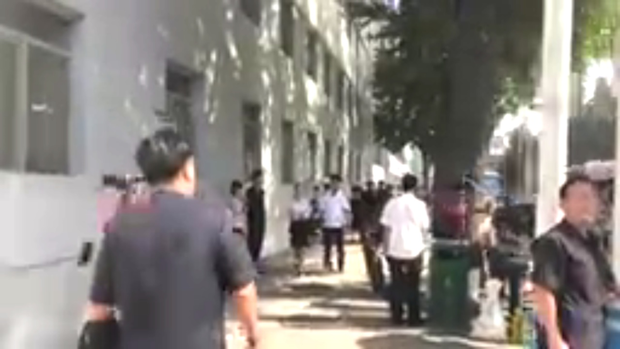

In [7]:
image = r"D:\My Hoa\work\VideoToAudioGuide\backend\frames\test1_20250227_095601\frame_0_00_04.jpg"

im = Image.open(image)
im.thumbnail([620,620], Image.Resampling.LANCZOS)
im

In [8]:
prompt = """
    Detect objects in the image. Return the output as a JSON list where each entry contains:
    - "box_2d": The 2D bounding box as [y_min, x_min, y_max, x_max].
    - "label": The name of the object (e.g., "bus", "car", "person").
    - "position": The relative position of the object in the image ("left", "right", "top", "bottom", "center", "top left", "bottom right", etc.).

    Ensure that:
    - "label" only contains the object's name, not its position.
    - "position" describes the object's placement.

    Do not return Markdown, explanations, or extra text. Only output valid JSON.
    """

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Check output
print(response.text)
     

```json
[
  {
    "box_2d": [
      497,
      508,
      781,
      566
    ],
    "label": "person",
    "position": "center"
  },
  {
    "box_2d": [
      494,
      615,
      875,
      703
    ],
    "label": "person",
    "position": "center"
  },
  {
    "box_2d": [
      514,
      861,
      1000,
      1000
    ],
    "label": "person",
    "position": "bottom right"
  },
  {
    "box_2d": [
      497,
      395,
      742,
      429
    ],
    "label": "person",
    "position": "center"
  },
  {
    "box_2d": [
      384,
      105,
      1000,
      385
    ],
    "label": "person",
    "position": "left"
  },
  {
    "box_2d": [
      505,
      367,
      668,
      401
    ],
    "label": "person",
    "position": "left"
  },
  {
    "box_2d": [
      505,
      462,
      781,
      508
    ],
    "label": "person",
    "position": "center"
  },
  {
    "box_2d": [
      523,
      725,
      801,
      783
    ],
    "label": "person",
    "position": "right"
  }
]
`

(1024, 576)


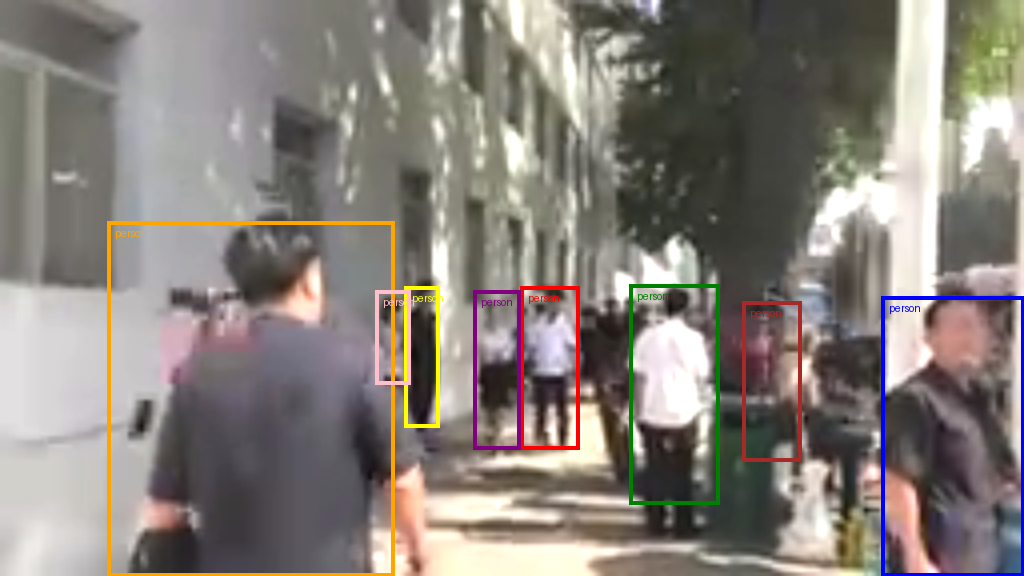

In [9]:
plot_bounding_boxes(im, response.text)
im

# Depth Estimation

## Config

In [10]:
from transformers import pipeline
from PIL import Image

pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
image = Image.open(r'D:\My Hoa\work\VideoToAudioGuide\backend\frames\test1_20250227_095601\frame_0_00_04.jpg')
depth = pipe(image)["depth"]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


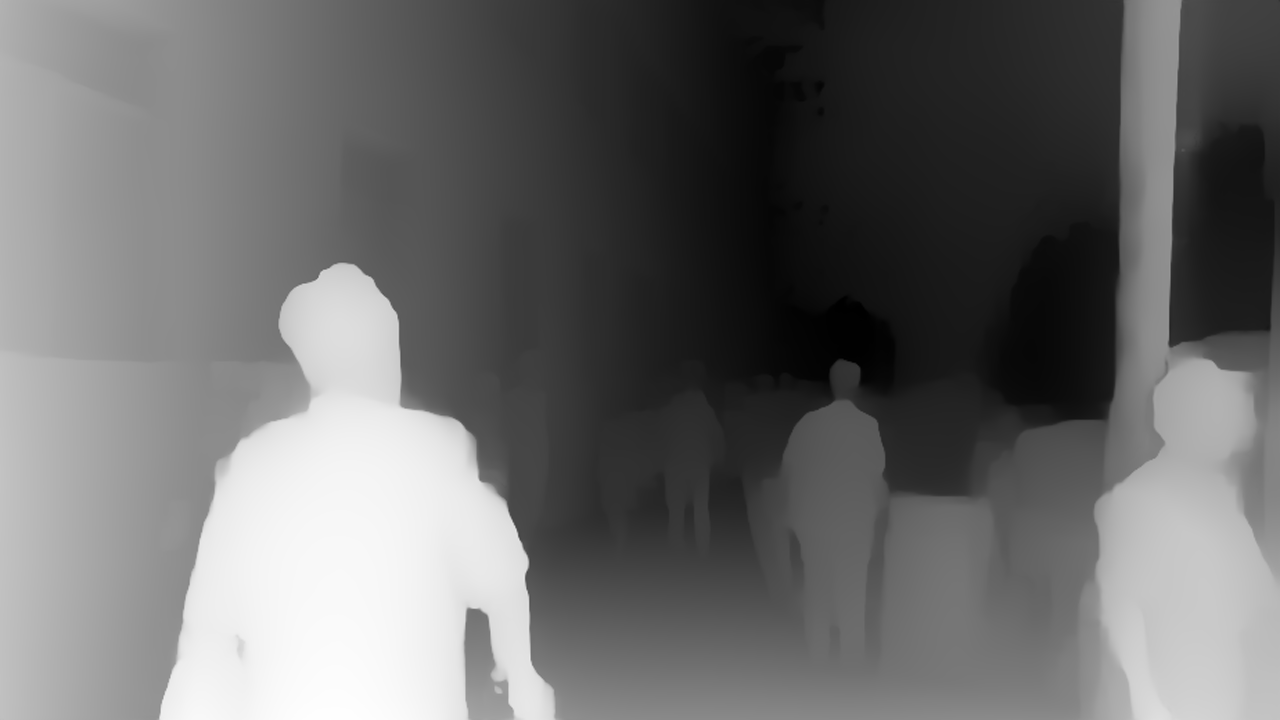

In [11]:
depth

# OD + DE

In [ ]:
def get_object_depths(image_path, objects):
    """
    Tính toán độ sâu cho mỗi object được detect bởi Gemini API
    
    Args:
        image_path (str): Đường dẫn đến ảnh
        objects (list): List các object từ Gemini API
    
    Returns:
        list: Danh sách objects với thông tin depth được thêm vào
    """
    try:
        objects = json.loads(objects)
    except json.JSONDecodeError as e:
        print(f"Lỗi parse JSON: {e}")
        return []
    
    # Đọc ảnh
    image = Image.open(image_path)
    
    # Lấy depth map
    depth_map = np.array(pipe(image)["depth"])
    height, width = depth_map.shape
    
    # Normalize depth map về range [0,1]
    print(f"Depth min: {depth_map.min()}, Depth max: {depth_map.max()}")
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    
    results = []
    for obj in objects:
        # Lấy tọa độ từ box_2d [y1, x1, y2, x2]
        y1, x1, y2, x2 = obj["box_2d"]
        
        # Chuyển đổi tọa độ về pixel thực tế
        x1_pixel = int(x1 * width / 1000)
        y1_pixel = int(y1 * height / 1000)
        x2_pixel = int(x2 * width / 1000)
        y2_pixel = int(y2 * height / 1000)
        
        # Đảm bảo tọa độ nằm trong ảnh
        x1_pixel = max(0, min(x1_pixel, width-1))
        y1_pixel = max(0, min(y1_pixel, height-1))
        x2_pixel = max(0, min(x2_pixel, width-1))
        y2_pixel = max(0, min(y2_pixel, height-1))
        
        try:
            # Lấy vùng depth tương ứng
            depth_region = depth_map[y1_pixel:y2_pixel, x1_pixel:x2_pixel]
            depth_mean = float(np.mean(depth_region))

            
            # Tạo kết quả
            result = obj.copy()
            result["depth"] = depth_mean
            results.append(result)
            
        except Exception as e:
            print(f"Lỗi xử lý object {obj['label']}: {str(e)}")
            result = obj.copy()
            result["depth"] = np.nan
            result["depth_stats"] = None
            results.append(result)
    
    # Sắp xếp theo độ sâu trung bình
    valid_results = [r for r in results if not np.isnan(r["depth"])]
    invalid_results = [r for r in results if np.isnan(r["depth"])]
    
    # Sắp xếp các kết quả hợp lệ từ gần tới xa
    valid_results.sort(key=lambda x: x["depth"])
    
    # Gộp lại và thêm distance rank
    final_results = valid_results + invalid_results
    
    # Gán rank từ 1 (gần nhất) đến N (xa nhất)
    for i, result in enumerate(reversed(final_results)):
        result["distance_rank"] = i + 1  # object gần nhất (depth nhỏ nhất) sẽ có rank = 1
    
    return final_results

In [48]:
import numpy as np
image_path = r"D:\My Hoa\work\VideoToAudioGuide\backend\frames\test1_20250227_095601\frame_0_00_04.jpg"
objects = parse_json(response.text)
results = get_object_depths(image_path, objects)

Depth min: 0, Depth max: 255


In [49]:
results

[{'box_2d': [497, 508, 781, 566],
  'label': 'person',
  'position': 'center',
  'depth': 0.17198366228495354,
  'distance_rank': 8},
 {'box_2d': [505, 462, 781, 508],
  'label': 'person',
  'position': 'center',
  'depth': 0.18206118662438145,
  'distance_rank': 7},
 {'box_2d': [523, 725, 801, 783],
  'label': 'person',
  'position': 'right',
  'depth': 0.264161897191309,
  'distance_rank': 6},
 {'box_2d': [497, 395, 742, 429],
  'label': 'person',
  'position': 'center',
  'depth': 0.2821741845171556,
  'distance_rank': 5},
 {'box_2d': [494, 615, 875, 703],
  'label': 'person',
  'position': 'center',
  'depth': 0.2953025210084033,
  'distance_rank': 4},
 {'box_2d': [505, 367, 668, 401],
  'label': 'person',
  'position': 'left',
  'depth': 0.33292959763548,
  'distance_rank': 3},
 {'box_2d': [514, 861, 1000, 1000],
  'label': 'person',
  'position': 'bottom right',
  'depth': 0.6870514213488158,
  'distance_rank': 2},
 {'box_2d': [384, 105, 1000, 385],
  'label': 'person',
  'positi

In [52]:
def visualize_results(image_path, results):
    """
    Hiển thị kết quả với bounding boxes và thông tin depth
    
    Args:
        image_path (str): Đường dẫn đến ảnh
        results (list): List các object với thông tin depth
    """
    import cv2
    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt
    
    # Đọc ảnh
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    
    # Copy ảnh để vẽ lên
    img_with_boxes = image.copy()
    
    # Màu cho các box (BGR format)
    colors = [
        (0, 0, 255),    # Đỏ - gần nhất
        (0, 165, 255),  # Cam
        (0, 255, 255),  # Vàng
        (0, 255, 0),    # Xanh lá
        (255, 0, 0)     # Xanh dương - xa nhất
    ]
    
    # Vẽ mỗi object
    for obj in results:
        # Lấy tọa độ và thông tin
        y1, x1, y2, x2 = obj["box_2d"]
        
        # Chuyển tọa độ về pixel
        x1 = int(x1 * width / 1000)
        y1 = int(y1 * height / 1000)
        x2 = int(x2 * width / 1000)
        y2 = int(y2 * height / 1000)
        
        # Lấy màu dựa trên distance_rank (index từ 0)
        color = colors[min(obj["distance_rank"]-1, len(colors)-1)]
        
        # Vẽ bounding box
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)
        
        # Chuẩn bị text hiển thị
        if np.isnan(obj["depth"]):
            text = f"{obj['label']} (rank: {obj['distance_rank']})"
        else:
            text = f"{obj['label']} (depth: {obj['depth']:.2f}, rank: {obj['distance_rank']})"
        
        # Vẽ nền cho text
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img_with_boxes, 
                     (x1, y1 - text_height - 5),
                     (x1 + text_width, y1),
                     color, -1)
        
        # Vẽ text
        cv2.putText(img_with_boxes, text,
                    (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 255), 1)
    
    # Chuyển từ BGR sang RGB cho matplotlib
    img_with_boxes = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    
    # Hiển thị ảnh
    plt.figure(figsize=(15, 10))
    plt.imshow(img_with_boxes)
    plt.axis('off')
    plt.title('Object Detection with Depth Information')
    
    # Thêm chú thích màu
    legend_elements = [plt.Line2D([0], [0], color=tuple(np.array(c)[::-1]/255), 
                                label=f'Rank {i+1}', linewidth=4)
                      for i, c in enumerate(colors)]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.show()

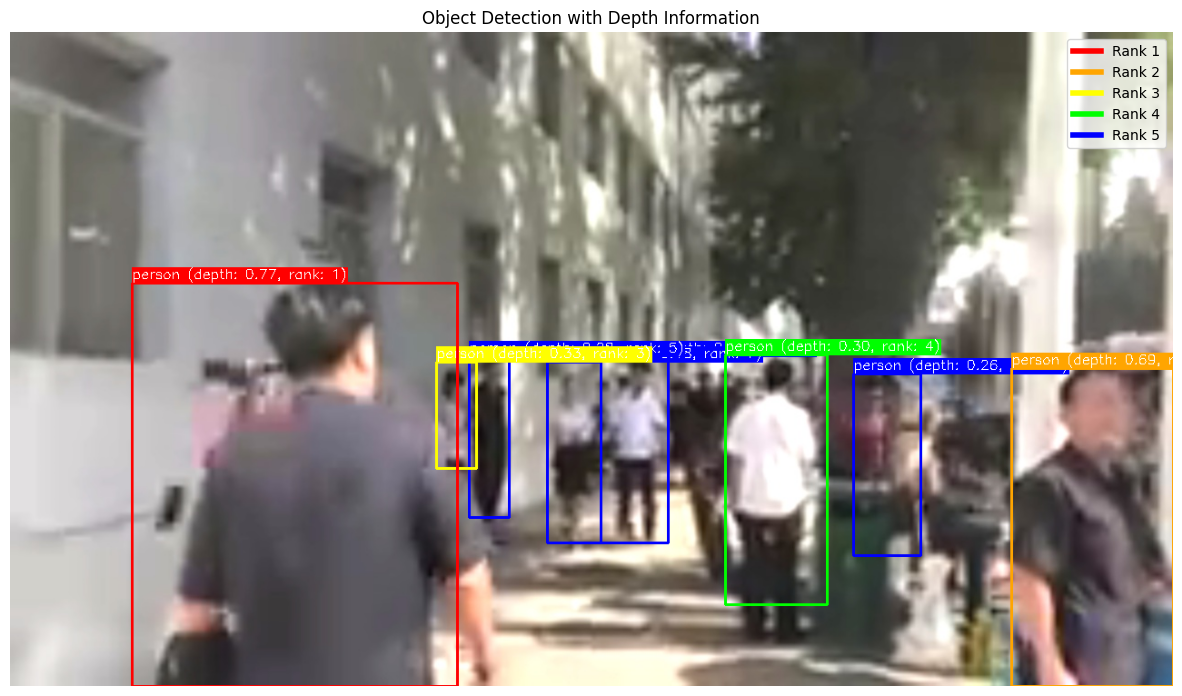

In [53]:
visualize_results(image_path, results)

Device set to use cuda:0


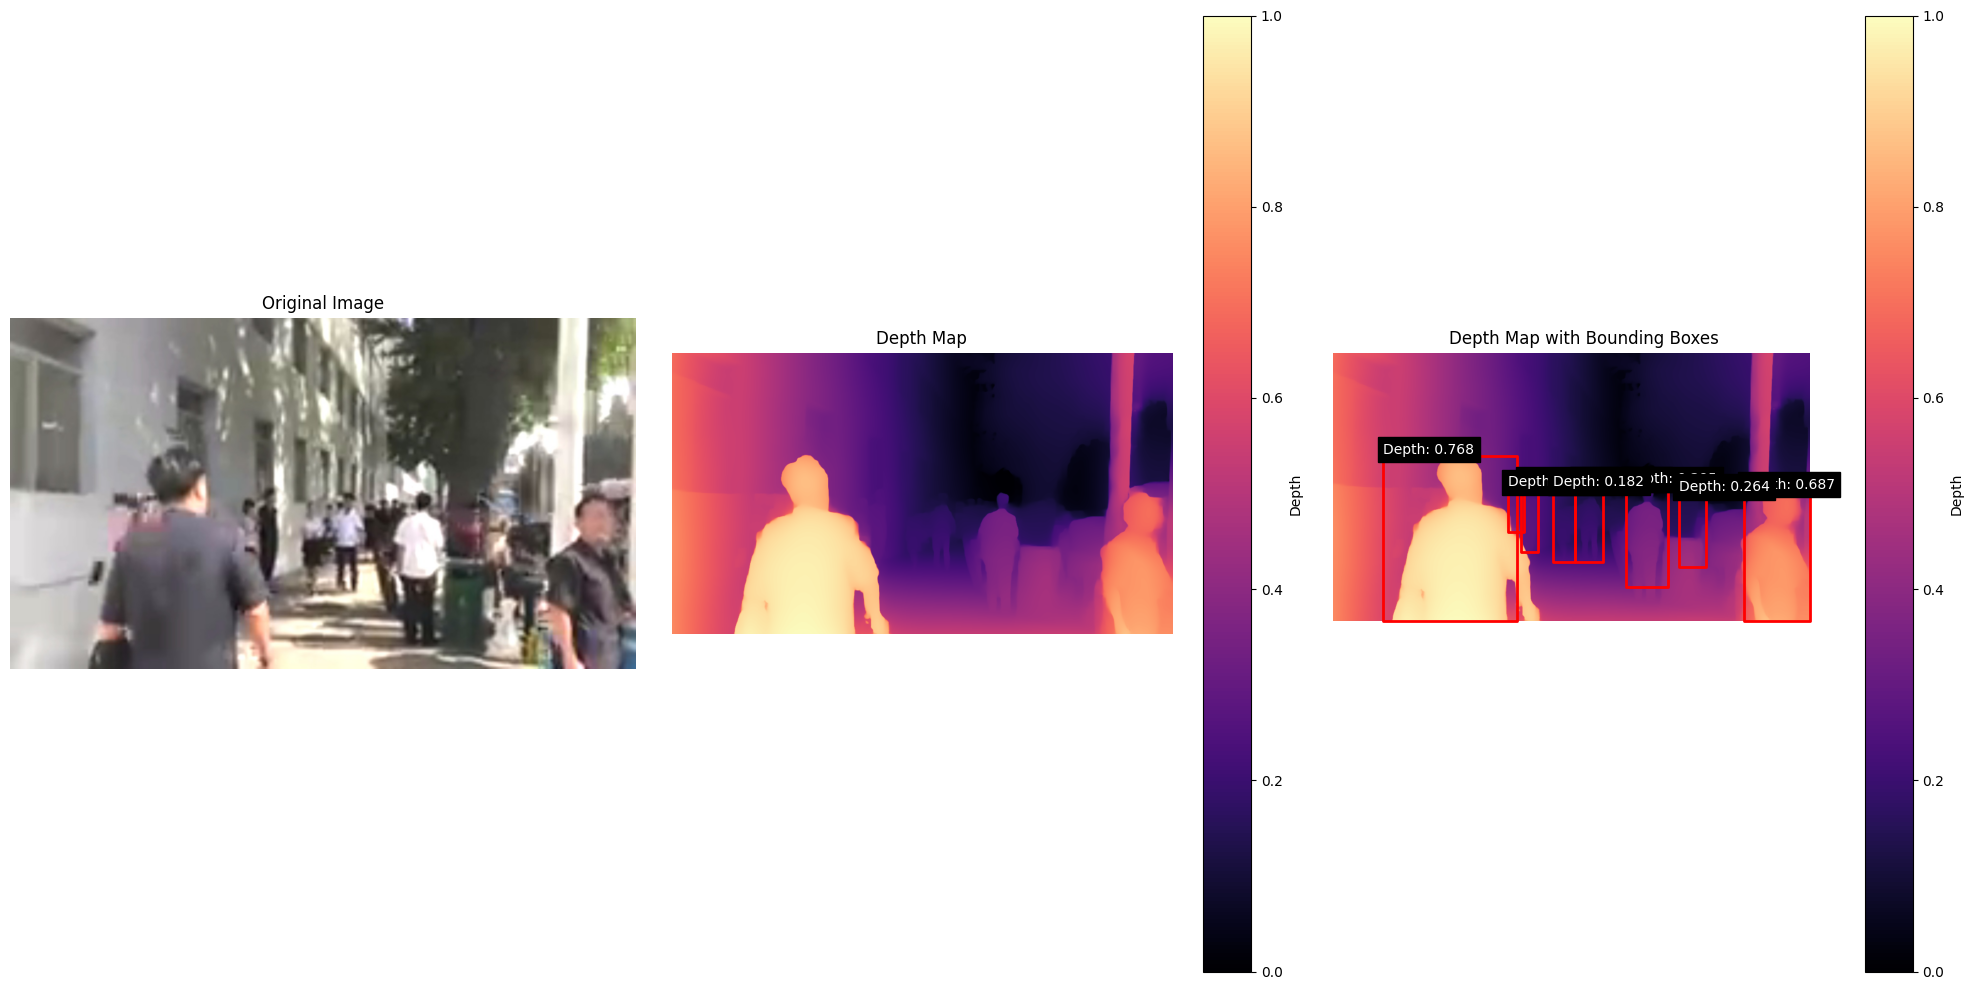

In [55]:
def analyze_depth_estimation(image_path, objects):
    """
    Phân tích chi tiết depth estimation để debug
    """
    from transformers import pipeline
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2

    try:
        objects = json.loads(objects)
    except json.JSONDecodeError as e:
        print(f"Lỗi parse JSON: {e}")
        return []

    # 1. Load ảnh và tạo depth map
    image = Image.open(image_path)
    pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
    depth_result = pipe(image)
    depth_map = np.array(depth_result["depth"])
    
    # Normalize depth map
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    
    # 2. Visualize depth map
    plt.figure(figsize=(20, 10))
    
    # 2.1 Ảnh gốc
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # 2.2 Depth map
    plt.subplot(132)
    plt.imshow(depth_map, cmap='magma')
    plt.colorbar(label='Depth')
    plt.title('Depth Map')
    plt.axis('off')
    
    # 2.3 Depth map với bounding boxes
    plt.subplot(133)
    depth_viz = plt.imshow(depth_map, cmap='magma')
    plt.colorbar(label='Depth')
    
    # Vẽ bounding boxes và in depth values
    height, width = depth_map.shape
    for obj in objects:
        y1, x1, y2, x2 = obj["box_2d"]
        
        # Chuyển tọa độ về pixel
        y1 = int(y1 * height / 1000)
        x1 = int(x1 * width / 1000)
        y2 = int(y2 * height / 1000)
        x2 = int(x2 * width / 1000)
        
        # Vẽ box
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r-', linewidth=2)
        
        # Tính và hiển thị depth trung bình trong box
        depth_region = depth_map[y1:y2, x1:x2]
        avg_depth = np.mean(depth_region)
        plt.text(x1, y1-5, f'Depth: {avg_depth:.3f}', 
                color='white', backgroundcolor='black')
    
    plt.title('Depth Map with Bounding Boxes')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Sử dụng
image_path = r"D:\My Hoa\work\VideoToAudioGuide\backend\frames\test1_20250227_095601\frame_0_00_04.jpg"
analyze_depth_estimation(image_path, objects)